In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import randrange
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from skorch import NeuralNetBinaryClassifier, NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Callback

In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)

In [3]:
def split_sequences(Xs, ys, n_steps):
    X, y = list(), list()
    for i in range(len(ys)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(ys):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = Xs[i: end_ix], ys[end_ix - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).squeeze()

In [4]:
df_path = "../merged_data/CAPE_BAAFFM_BCI_CCI_CLI_IJC_PMIC_T10Y2Y_T10Y3M_vs_USRESCD.csv"
features = ['CAPE', "BAAFFM", "BCI", "CCI", "CLI", "IJC", "PMIC", "T10Y2Y", "T10Y3M"]
model_names = ["Logistic Regression", "Penalized SVM", "Random Forest", "LSTM"]
LSTM_length = 10


In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()

        self.lstm = nn.LSTM(input_size=len(features), hidden_size=LSTM_length, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.dense = nn.Linear(LSTM_length, 1)

    def forward(self, X, **kwargs):
        output, hidden = self.lstm(X)
        X = self.dense(self.dropout(output[:, -1, :]))
        return X

    
class FixRandomSeed(Callback):
    
    def __init__(self, seed=1):
        self.seed = seed
    
    def initialize(self):
        print("setting random seed to: ",self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        
        try:
            random.seed(self.seed)
        except NameError:
            import random
            random.seed(self.seed)

        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic=True
        
        
def get_LSTM_model():
    model = NeuralNetBinaryClassifier(
        MyModule,
        optimizer=Adam,
        max_epochs=10,
        lr=1e-4,
        batch_size=64,
        iterator_train__shuffle=True,
        verbose=0,
        callbacks=[FixRandomSeed()]
    )
    return model

In [6]:
get_models = [lambda: linear_model.LogisticRegression(), lambda: svm.SVC(kernel='linear',\
    class_weight='balanced', probability=True, max_iter=1000, random_state=1), lambda: RandomForestClassifier(random_state=1), lambda: get_LSTM_model()]
target_variable = "USRECD"

In [7]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date", drop=True)
df = df.dropna()


In [8]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 180 # This is the lag in days we introduce to the predictor variable so that we assess 
              # the indicator's ability to predict the target variable this many steps into the future.

df_x = df.iloc[:-lag_of_y][features]
df_y = df.iloc[lag_of_y:][target_variable]
        
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, shuffle=False)


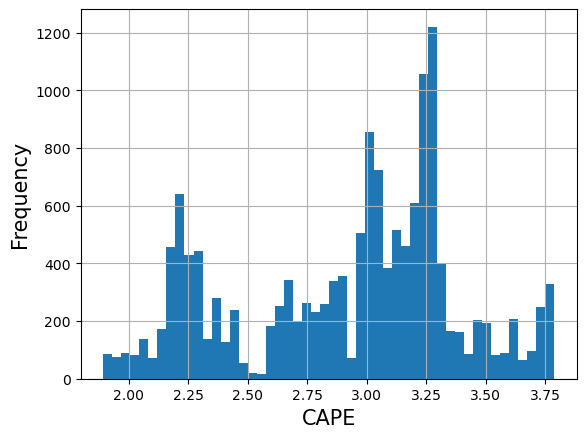

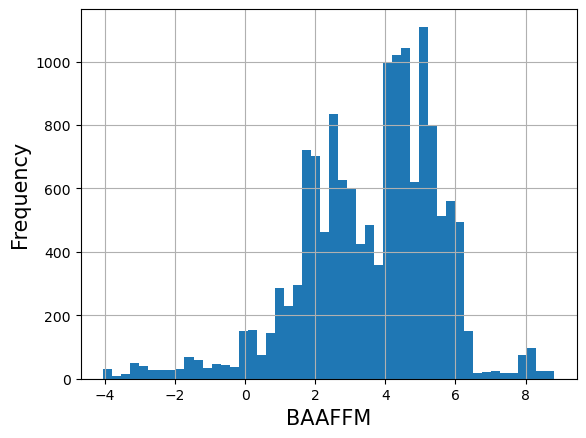

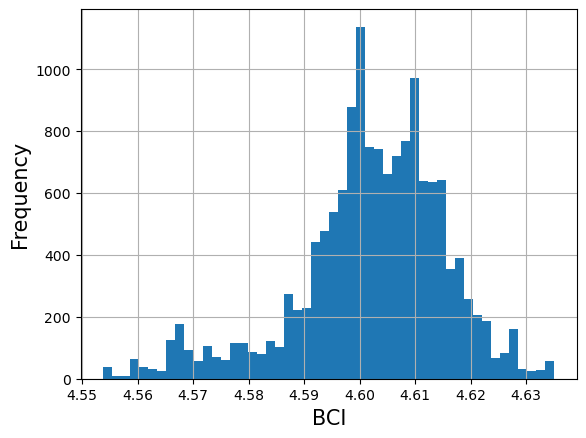

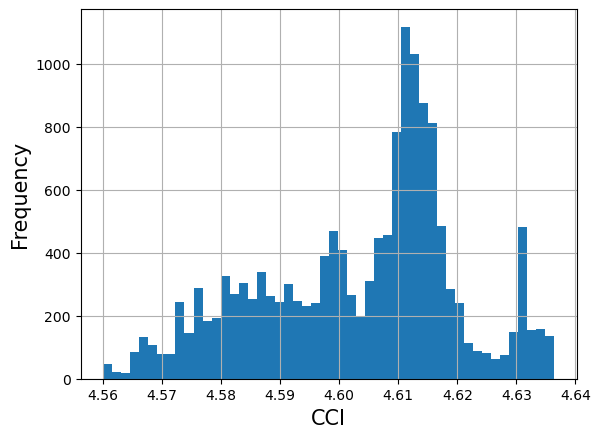

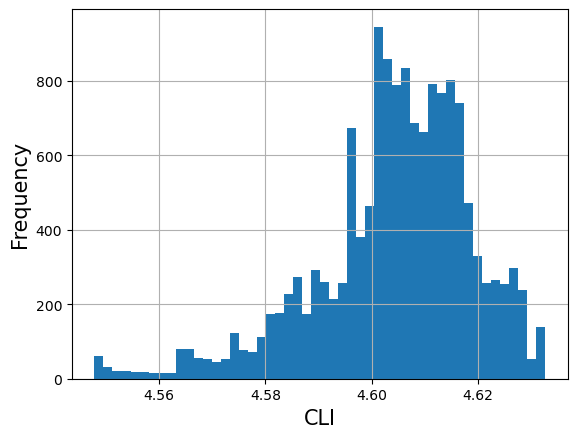

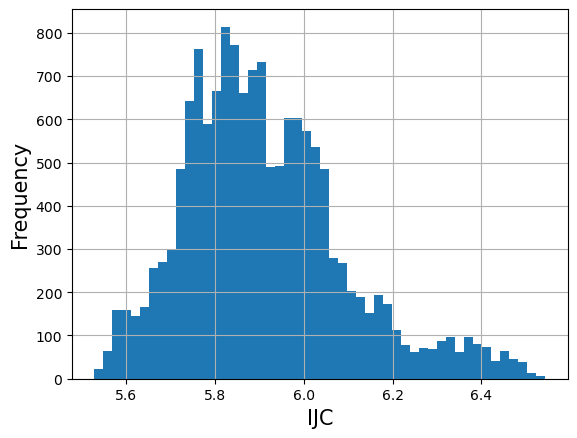

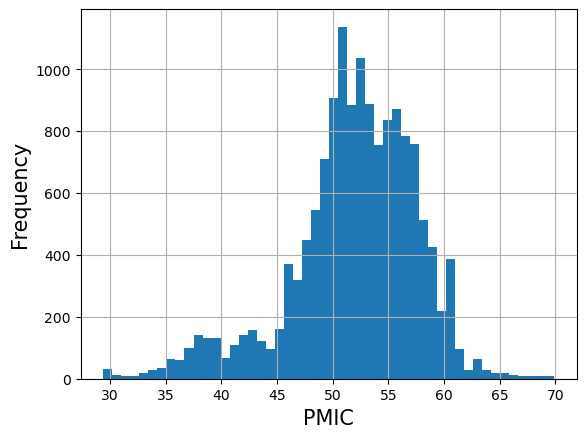

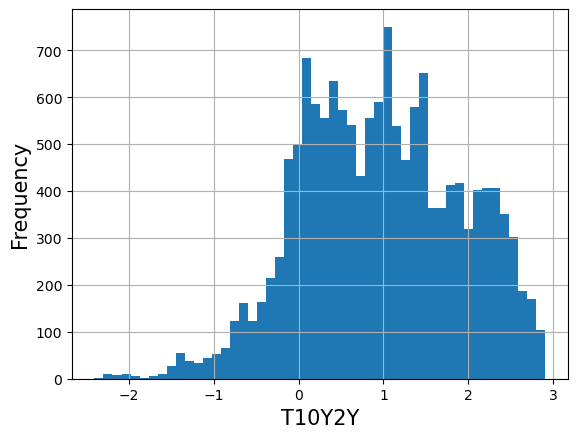

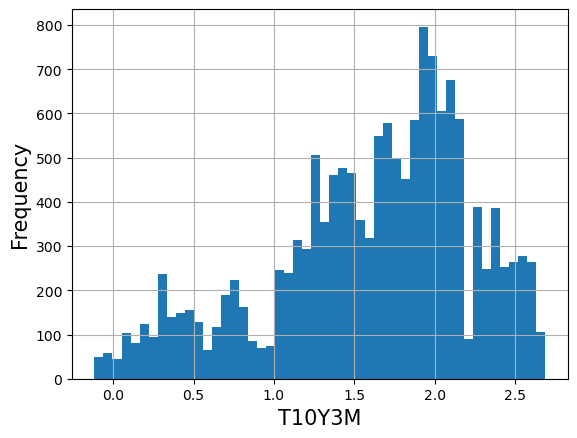

In [9]:
# Histrograms of the features in training set before any scaling
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()


 ## Validation

In [10]:
# Do a time series cross-validation on the test set by splitting it into k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 3 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)
pd.options.mode.chained_assignment = None

AUC_ROCs = dict()
ACCs = dict()


In [11]:
## Classification
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print(model_name)
    AUC_ROCs[model_name] = 0
    ACCs[model_name] = 0
    for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
        X_train_fold, X_validation_fold = X_train.iloc[train_index,][features], X_train.iloc[test_index,][features]
        y_train_fold, y_validation_fold = y_train.iloc[train_index,], y_train.iloc[test_index,]

        scalers = dict()
        for feature in features:
            scalers[feature] = StandardScaler()
            scalers[feature].fit(X_train_fold[[feature]]) # Do z-score scaling on the training fold...
            X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
            X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]]) # ...and use the same
            # scaling parameters to transform the validation fold to the same scale with it (to avoid data leakage)

        if model_name == 'LSTM':
            X_train_fold_original = X_train_fold.copy()
            y_train_fold_original = y_train_fold.copy()
            X_train_fold, y_train_fold = split_sequences(X_train_fold.to_numpy(), y_train_fold.to_numpy(), n_steps=LSTM_length)
            X_train_fold = X_train_fold.astype(np.float32)
            y_train_fold = y_train_fold.astype(np.float32)
            X_validation_fold = pd.concat([X_train_fold_original.iloc[-LSTM_length+1:], X_validation_fold])
            y_validation_fold = pd.concat([y_train_fold_original.iloc[-LSTM_length+1:], y_validation_fold])
            X_validation_fold, y_validation_fold = split_sequences(X_validation_fold.to_numpy(), y_validation_fold.to_numpy(), n_steps=LSTM_length)
            X_validation_fold = X_validation_fold.astype(np.float32)
            y_validation_fold = y_validation_fold.astype(np.float32)

        model = get_model()
        if model_name != 'LSTM':
            model.fit(X_train_fold[features], y_train_fold)
            positive_probs = [p[1] for p in model.predict_proba(X_validation_fold[features])]
        else:
            model.fit(X_train_fold, y_train_fold)
            positive_probs = [p[1] for p in model.predict_proba(X_validation_fold)]

        AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
        AUC_ROCs[model_name] += AUC_ROC

        if model_name != 'LSTM':
            predictions = model.predict(X_validation_fold[features])
        else:
            predictions = model.predict(X_validation_fold)

        ACC = accuracy_score(y_validation_fold, predictions)
        ACCs[model_name] += ACC
        print("AUC_ROC:", AUC_ROC, "\tAccuracy:", ACC)

    AUC_ROCs[model_name] /= splits
    ACCs[model_name] /= splits

for model_name in model_names:
    print(model_name)
    print(f"Average AUC ROC: {AUC_ROCs[model_name]}")
    print(f"Average accuracy: {ACCs[model_name]}")


USRECD
Logistic Regression
AUC_ROC: 0.8135053701607154 	Accuracy: 0.9129961935834693
AUC_ROC: 0.8607858254485043 	Accuracy: 0.9336595976073954
AUC_ROC: 0.8176937939120326 	Accuracy: 0.8512778684067428
Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.6386232261697247 	Accuracy: 0.0929853181076672


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.8486244116214899 	Accuracy: 0.8363240891789016


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.7937135106445715 	Accuracy: 0.855084284937466
Random Forest
AUC_ROC: 0.6860633397427834 	Accuracy: 0.933931484502447
AUC_ROC: 0.9231157566094123 	Accuracy: 0.9336595976073954
AUC_ROC: 0.8669056325930995 	Accuracy: 0.8512778684067428
LSTM
setting random seed to:  1
AUC_ROC: 0.8376450362702992 	Accuracy: 0.933931484502447
setting random seed to:  1
AUC_ROC: 0.9908592474483707 	Accuracy: 0.9336595976073954
setting random seed to:  1
AUC_ROC: 0.6414836712780201 	Accuracy: 0.8512778684067428
Logistic Regression
Average AUC ROC: 0.8306616631737507
Average accuracy: 0.8993112198658691
Penalized SVM
Average AUC ROC: 0.7603203828119286
Average accuracy: 0.5947978974080116
Random Forest
Average AUC ROC: 0.8253615763150984
Average accuracy: 0.906289650172195
LSTM
Average AUC ROC: 0.8233293183322301
Average accuracy: 0.906289650172195


 ## Test

In [12]:
y_test.value_counts()


0    1574
1      61
Name: USRECD, dtype: int64

In [13]:
X_train = X_train.copy()
X_test = X_test.copy()

all_scalers = dict()
for feature in features:
    all_scalers[feature] = StandardScaler()
    all_scalers[feature].fit(X_train[[feature]]) # Do z-score scaling on the training set/split...
    X_train[feature] = all_scalers[feature].transform(X_train[[feature]])
    X_test[feature] = all_scalers[feature].transform(X_test[[feature]]) # ...and use the same
    # scaling parameters to transform the test set/split to the same scale with it (to avoid data leakage)


In [14]:
for feature in features:
    print(all_scalers[feature].mean_)


[2.92]
[3.59]
[4.6]
[4.6]
[4.6]
[5.91]
[51.92]
[0.97]
[1.61]


USRECD

Logistic Regression
Test AUC_ROC: 0.9476742974982815 
Test Accuracy: 0.962691131498471

Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test AUC_ROC: 0.9175953506780261 
Test Accuracy: 0.962691131498471

Random Forest
Test AUC_ROC: 0.9225894140437852 
Test Accuracy: 0.962691131498471

LSTM
setting random seed to:  1
Test AUC_ROC: 0.7429020767804695 
Test Accuracy: 0.962079510703364

Baseline #1: naively always guess 0 (no recession)
ROC AUC: 0.5 
Accuracy: 0.962691131498471
Baseline #2: naively guess 1 (recession) random 10% of the time:
ROC AUC: 0.5078217759910013 
Accuracy: 0.8715596330275229
Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time
ROC AUC: 0.5 
Accuracy: 0.962691131498471


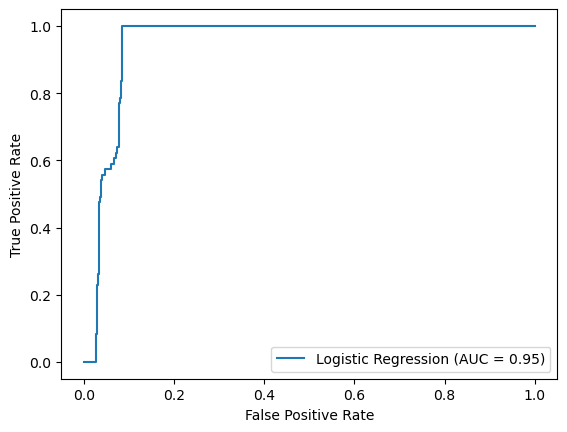

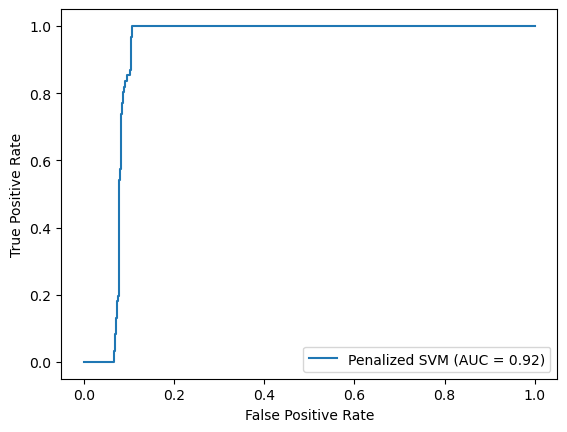

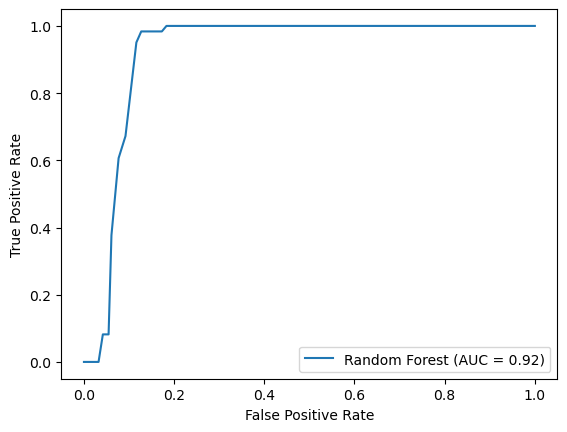

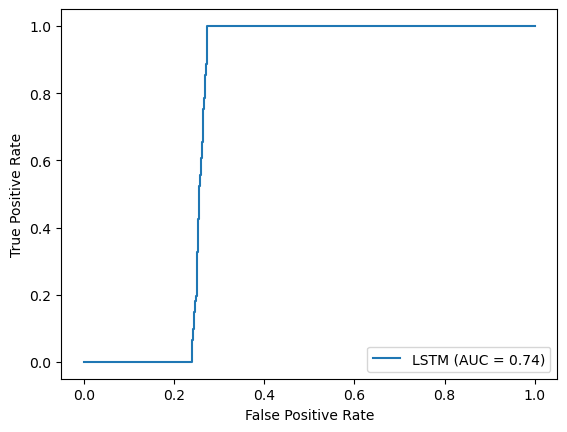

In [15]:
## Classification
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print()
    print(model_name)
    if model_name == 'LSTM':
        current_X_train, current_y_train = split_sequences(X_train[features].to_numpy(), y_train.to_numpy(), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        current_y_train = current_y_train.astype(np.float32)
        current_X_test = pd.concat([X_train.iloc[-LSTM_length+1:], X_test])
        current_y_test = pd.concat([y_train.iloc[-LSTM_length+1:], y_test])
        current_X_test, current_y_test = split_sequences(current_X_test[features].to_numpy(), current_y_test.to_numpy(), n_steps=LSTM_length)
        current_X_test = current_X_test.astype(np.float32)
        current_y_test = current_y_test.astype(np.float32)

    model = get_model()
    if model_name != 'LSTM':
        model.fit(X_train[features], y_train)
        positive_probs = [p[1] for p in model.predict_proba(X_test[features])]
        AUC_ROC = metrics.roc_auc_score(y_test, positive_probs)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, positive_probs)
    else:
        model.fit(current_X_train, current_y_train)
        positive_probs = [p[1] for p in model.predict_proba(current_X_test)]
        AUC_ROC = metrics.roc_auc_score(current_y_test, positive_probs)
        fpr, tpr, thresholds = metrics.roc_curve(current_y_test, positive_probs)

    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    display.plot()
    if model_name != 'LSTM':
        predictions = model.predict(X_test[features])
        ACC = accuracy_score(y_test, predictions)
    else:
        predictions = model.predict(current_X_test)
        ACC = accuracy_score(current_y_test, predictions)
    print("Test AUC_ROC:", AUC_ROC, "\nTest Accuracy:", ACC)

print()
total = y_test.shape[0]
print("Baseline #1: naively always guess 0 (no recession)\nROC AUC:", 
    metrics.roc_auc_score(y_test, np.zeros(total)), 
    "\nAccuracy:", accuracy_score(y_test, np.zeros(total)))

nums = np.zeros(total)
nums[:total//10] = 1
np.random.shuffle(nums)
print("Baseline #2: naively guess 1 (recession) random 10% of the time:\nROC AUC:", 
    metrics.roc_auc_score(y_test, nums), 
    "\nAccuracy:", accuracy_score(y_test, nums))

nums = np.zeros(total)
for i in range(0, total//3650):
    start = randrange(total)
    for j in range(0, 365):
        nums[start + j] = 1
print("Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time\nROC AUC:", 
    metrics.roc_auc_score(y_test, nums), 
    "\nAccuracy:", accuracy_score(y_test, nums))


## Final predictions

In [16]:
extended_dates = df.iloc[-lag_of_y:].index.shift(lag_of_y, freq="d").tolist()
pickle.dump(extended_dates, open('../predictions/USRECD_extended_dates.pkl', 'wb'))
df_test = df.iloc[-lag_of_y:][features]

In [17]:
print(target_variable)
for model_name, get_model in zip(model_names, get_models):
    print()
    print(model_name)
    model = get_model()
    if model_name != 'LSTM':
        model.fit(df_x[features], df_y)
        predictions = model.predict(df_test[features])
    else:
        current_X_train, current_y_train = split_sequences(df_x[features].to_numpy(), df_y.to_numpy(), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        current_y_train = current_y_train.astype(np.float32)
        model.fit(current_X_train, current_y_train)
        current_df_test = df.iloc[-lag_of_y-LSTM_length+1:][features]
        current_df_test = current_df_test.astype(np.float32)
        current_df_test, _ = split_sequences(current_df_test.to_numpy(), np.ones(len(current_df_test)), n_steps=LSTM_length)
        current_X_train = current_X_train.astype(np.float32)
        predictions = model.predict(current_df_test)
    pickle.dump(predictions, open('../predictions/' + model_name + '_' + target_variable + '.pkl', 'wb'))

USRECD

Logistic Regression

Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Random Forest

LSTM
setting random seed to:  1
